##Setting up Packages and Installation for the projects

In [ ]:
!pip install kaggle

In [ ]:
# Mount your Google Drive files Following code make mount your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Now upload the kaggle.json file
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alessandroea","key":"59ff2ef98f952b274456cce8323519b5"}'}

In [ ]:
# make sure kaggle.json file is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Jan 10 18:44 kaggle.json


In [ ]:
# Install kaggle API client
!pip install -q kaggle

In [ ]:
#kaggle API client expects the file to be in ~/.kaggle
#so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# we need to set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# check your directory before downloading the datasets
!pwd

/content


In [ ]:
# list all available datasets
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18616  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11284  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5795  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3973  
nickuzmenkov/nih-chest-xrays-tfrecords                      NIH Chest X-rays

In [ ]:
# download the required dataset from kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 331M/346M [00:03<00:00, 86.9MB/s]
100% 346M/346M [00:03<00:00, 95.0MB/s]


In [ ]:
ls


gdrive/  intel-image-classification.zip  kaggle.json  sample_data/


In [ ]:
#If your file is a zip file you can unzip with the following code
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
ls

gdrive/                         kaggle.json   seg_pred/  seg_train/
intel-image-classification.zip  sample_data/  seg_test/


In [ ]:
# https://www.kaggle.com/arbazkhan971/image-classification-using-cnn-94-accuracy

In [ ]:
!pip install fastai

In [ ]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
import matplotlib.image as mpimg

##Starting the ML analysis

##Analysis of the data

In [ ]:
x  = '/content/seg_train/seg_train'
path = Path(x)
path.ls()

[PosixPath('/content/seg_train/seg_train/glacier'),
 PosixPath('/content/seg_train/seg_train/buildings'),
 PosixPath('/content/seg_train/seg_train/sea'),
 PosixPath('/content/seg_train/seg_train/street'),
 PosixPath('/content/seg_train/seg_train/mountain'),
 PosixPath('/content/seg_train/seg_train/forest')]

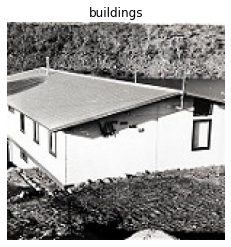

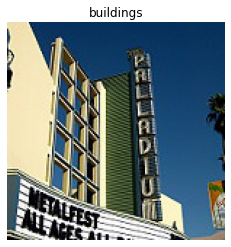

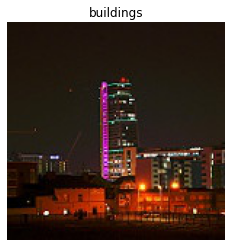

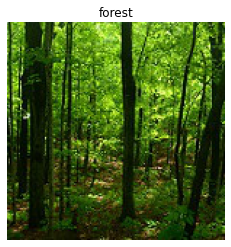

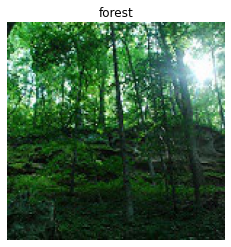

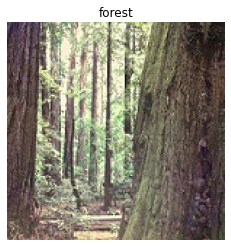

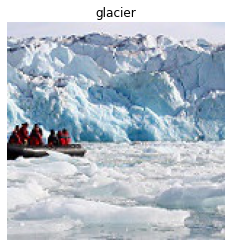

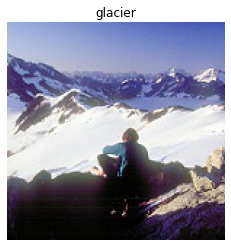

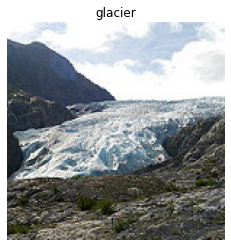

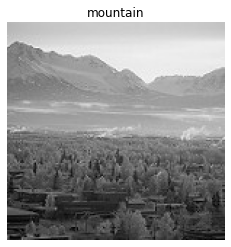

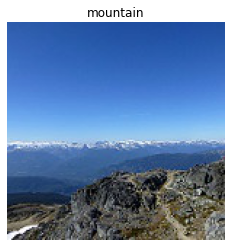

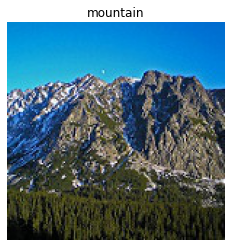

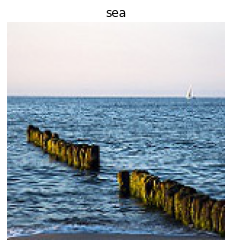

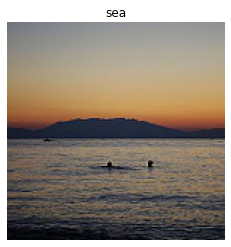

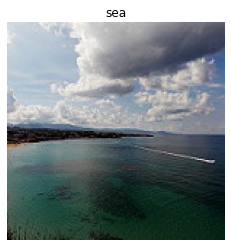

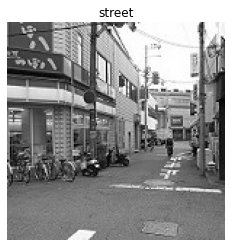

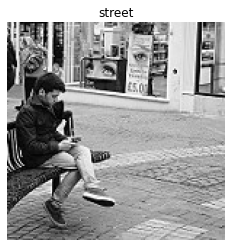

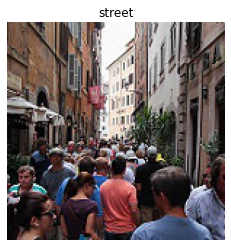

In [ ]:
#Get Label names
data_dir = pathlib.Path(x)
folder = x
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))


#Visualise Random Images
random_image = random.sample(os.listdir(folder+'/buildings'),1)
img = mpimg.imread(folder+'/buildings' + "/"+random_image[0])

for i in class_names:
    for x in range(3):
        plt.figure()
        random_image = random.sample(os.listdir(folder+'/'+i),1)
        img = mpimg.imread(folder+'/'+i + "/"+random_image[0])
        plt.imshow(img)
        plt.title(i)
        plt.axis('off')

###Train Data

In [ ]:
# Train Folder
train_path = '/content/seg_train/'
print("Train Folders: \n")
for folder in os.listdir(train_path + "seg_train"):
    files = glob.glob(train_path + "seg_train/" + folder +"/*.jpg") #list of paths matching a pathname pattern.
    print(f'({folder}): {len(files)} image')

Train Folders: 

(glacier): 2404 image
(buildings): 2191 image
(sea): 2274 image
(street): 2382 image
(mountain): 2512 image
(forest): 2271 image


In [ ]:
# Images size in train folder

image_train_size = []
for folder in os.listdir(train_path + "seg_train"):
    files = glob.glob(train_path + "seg_train/" + folder +"/*.jpg")
    for file in files:
        img = cv2.imread(file)
        image_train_size.append(img.shape)
    
pd.Series(image_train_size).value_counts()

(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(123, 150, 3)        2
(142, 150, 3)        2
(144, 150, 3)        2
(108, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(136, 150, 3)        2
(119, 150, 3)        1
(133, 150, 3)        1
(100, 150, 3)        1
(140, 150, 3)        1
(131, 150, 3)        1
(149, 150, 3)        1
(105, 150, 3)        1
(141, 150, 3)        1
(115, 150, 3)        1
(76, 150, 3)         1
(110, 150, 3)        1
(120, 150, 3)        1
(147, 150, 3)        1
(102, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(81, 150, 3)         1
(124, 150, 3)        1
(97, 150, 3)         1
dtype: int64

###Test Data

In [ ]:
# Test Folder
test_path = '/content/seg_test/'
print("Test Folders: \n")
for folder in os.listdir(test_path + "seg_test"):
    files = glob.glob(test_path + "seg_test/" + folder + "/*.jpg")
    print(f'({folder}): {len(files)} image')

Test Folders: 

(glacier): 553 image
(buildings): 437 image
(sea): 510 image
(street): 501 image
(mountain): 525 image
(forest): 474 image


In [ ]:
# Images size in test folder

image_test_size = []
for folder in os.listdir(test_path + "seg_test"):
    files = glob.glob(test_path + "seg_test/" + folder + "/*.jpg")
    for file in files:
        img = cv2.imread(file)
        image_test_size.append(img.shape)
        
pd.Series(image_test_size).value_counts()

(150, 150, 3)    2993
(72, 150, 3)        1
(110, 150, 3)       1
(76, 150, 3)        1
(141, 150, 3)       1
(81, 150, 3)        1
(149, 150, 3)       1
(131, 150, 3)       1
dtype: int64

###Pred Data

In [ ]:
# Pred Folder
pred_path = '/content/seg_pred/'
files = glob.glob(pred_path + "seg_pred/" + "/*.jpg")
print(f'Predection folder has: {len(files)} image')

Predection folder has: 7301 image


In [ ]:
# Images size in pred folder

image_pred_size = []
files = glob.glob(pred_path + "seg_pred/" + "/*.jpg")
for file in files:
    img = cv2.imread(file)
    image_pred_size.append(img.shape)

pd.Series(image_pred_size).value_counts()   

(150, 150, 3)    7288
(100, 150, 3)       1
(124, 150, 3)       1
(133, 150, 3)       1
(139, 150, 3)       1
(112, 150, 3)       1
(129, 150, 3)       1
(374, 500, 3)       1
(144, 150, 3)       1
(108, 150, 3)       1
(126, 150, 3)       1
(143, 150, 3)       1
(149, 150, 3)       1
(131, 150, 3)       1
dtype: int64

##Creating the model

In [ ]:
#ImageDataBunch: validation dataset
#path: path 
#train="." : training dataset, present in the current folder
#valid_pct=0.2 : instruction to create a validation dataset with 20% of original data 
#size=224 : it means that the images usually have size 224x224; this is for STANDARISATION
#ds_tfms=get_transforms() : data transformation, I use the get_transforms method (flip images horizontally)
#normalize(imagenet_stats) : normalise all the images we use to build the model
# np.random.seed(40) to get the same random validation dataset everytime we run the command by specying a random seed


In [ ]:
# Data Loading For training
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

In [ ]:
#Looking at the classes of the dataset
print(data.classes)
len(data.classes)
data.c

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


6

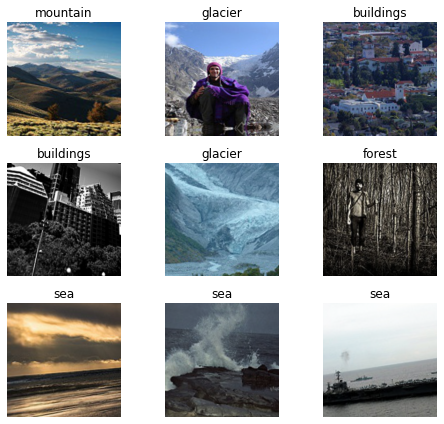

In [ ]:
# Data Explorations
data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)

In [ ]:
#method of Transfer Learning to train our model
#resnet18: train model architecture
#ResNet18 which is a pretty powerful CNN model trained on ImageNet dataset
#existing model that has already been trained for the particular task of image classification

In [ ]:
# Create Model
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#Once we have the learner object, we can utilize the lr_find function to find an optimal learning rate 
#for our model. Looking at the loss vs learning rate profile, 
#we should select the learning rate where the loss is minimum or a rate slightly below that point. 
#It’s good to be conservative with learning rates because in my personal opinion, 
#delayed convergence is more tolerable than overshooting the optimal point.

#lr_find function : find an optimal learning rate for our model

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


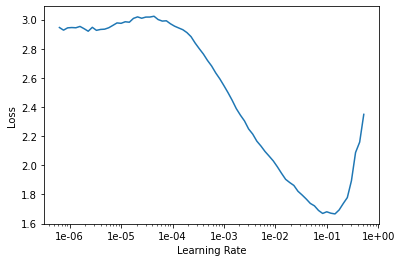

In [ ]:
# Finding LR
learn.lr_find()
learn.recorder.plot(suggestions=True)

In [ ]:
# Learning rate for data training
lr1 = 1e-3
lr2 = 1e-1

#Training the model

In [ ]:
# Train Model - 5 epochs
learn.fit_one_cycle(5,slice(lr1,lr2))  #40

epoch,train_loss,valid_loss,accuracy,time
0,0.658992,0.424165,0.905916,33:48


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

In [ ]:
# Unfreeze the previous layer and check for 
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestions=True)

In [ ]:
# New learning rate take from the above chart
lr3 = 1e-4
lr4 = 1e-5

In [ ]:
learn.fit_one_cycle(5,slice(lr4,lr3))

In [ ]:
learn.recorder.plot_losses()

#Interpreting the results

In [ ]:
#handy tools in fast.ai library “most_confused” which basically tells us where the model found the images most confusing while training

In [ ]:
# Interpret the results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(6,figsize = (25,5))

#Apply the model to predict data to predict the label of an image

In [ ]:
#Taking a random file from test folder
import os, random
folder = '/content/seg_test/seg_test'
subfolder = random.choice(os.listdir(folder)) #Randomly selecting the folder
path = folder + '/' + subfolder
rnd_img = random.choice(os.listdir(path))

rnd_img_path = path + '/' + rnd_img

# '/content/seg_test/seg_test'

In [ ]:
#Showing the picture
img = mpimg.imread(rnd_img_path)
plt.imshow(img)

In [ ]:
img = open_image(rnd_img_path)
#'/content/seg_test/seg_test/glacier/21982.jpg'
print(learn.predict(img)[0])

In [ ]:
learn.export(file = Path("/kaggle/working/export.pkl"))
learn.model_dir = "/kaggle/working"
learn.save("model",return_path=True)